# Health Prediction Model - Comprehensive Error Analysis

This notebook implements a systematic error analysis following ML best practices for classification models. We analyze misclassifications, model behavior, feature impacts, and performance across different subgroups to understand model limitations and guide improvements.

## Key Objectives:
- ✅ **Label Distribution Analysis**: Class imbalance, data quality issues
- ✅ **Performance Breakdown**: Error analysis by demographic subgroups
- ✅ **Confusion Matrix Analysis**: Deep dive into FP, FN, TP, TN patterns
- ✅ **Feature Impact Analysis**: SHAP values, feature importance, correlations
- ✅ **Model Behavior Analysis**: Training curves, threshold sensitivity
- ✅ **Error Concentration**: Spatial analysis of misclassifications
- ✅ **Calibration Analysis**: Probability calibration assessment
- ✅ **Domain-Specific Insights**: Health-specific error patterns

## Dataset Context:
- **42,377 total samples** (29,663 train, 6,357 validation, 6,357 test)
- **Class imbalance**: 7.84:1 ratio (negative:positive health outcomes)
- **Target**: Binary health outcome prediction
- **Best Model**: Random Forest Tuned (Test F1: 0.3832)

In [ ]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve,
    roc_curve, roc_auc_score, f1_score, precision_score, recall_score,
    brier_score_loss
)
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve
import shap
import joblib

# Suppress all warnings including sklearn feature name warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('sklearn').setLevel(logging.ERROR)
pd.options.mode.chained_assignment = None  # Suppress pandas warnings

# Project setup
PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Import project modules
try:
    from src.evaluate_models import load_splits, load_models
    from src.utils import load_model
except ImportError as e:
    print(f"Import error: {e}")
    print("Make sure you're running from the notebooks directory")

# Set up paths
RESULTS_DIR = PROJECT_ROOT / "results"
METRICS_DIR = RESULTS_DIR / "metrics"
PLOTS_DIR = RESULTS_DIR / "plots"
MODELS_DIR = RESULTS_DIR / "models"

# Ensure directories exist
for directory in [METRICS_DIR, PLOTS_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✓ All imports loaded successfully")
print(f"✓ Project root: {PROJECT_ROOT}")
print(f"✓ Results directory: {RESULTS_DIR}")

# Load data and models
print("\n📊 Loading data and models...")
splits = load_splits()
models, scaler = load_models(input_dim=splits['X_train'].shape[1], include_tuned=True)

X_train = splits['X_train']
X_val = splits['X_val'] 
X_test = splits['X_test']
y_train = splits['y_train'].astype(int)
y_val = splits['y_val'].astype(int)
y_test = splits['y_test'].astype(int)

print(f"✓ Data loaded: {X_train.shape[0]:,} train, {X_val.shape[0]:,} val, {X_test.shape[0]:,} test samples")
print(f"✓ Models loaded: {len(models)} models available")
print(f"✓ Class distribution (train): {y_train.value_counts().to_dict()}")

# Load feature names for interpretability
feature_names_path = PROJECT_ROOT / "data" / "processed" / "feature_names.csv"
if feature_names_path.exists():
    try:
        # Skip comment lines and use proper column names
        feature_names_df = pd.read_csv(feature_names_path, comment='#')
        if 'cleaned_name' in feature_names_df.columns:
            feature_names = feature_names_df['cleaned_name'].tolist()
        elif 'feature' in feature_names_df.columns:
            feature_names = feature_names_df['feature'].tolist()
        else:
            feature_names = feature_names_df.iloc[:, 1].tolist()  # Use second column
        print(f"✓ Feature names loaded: {len(feature_names)} features")
    except Exception as e:
        print(f"⚠️ Error loading feature names: {e}")
        feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
        print(f"✓ Using generic feature names: {len(feature_names)} features")
else:
    feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
    print(f"⚠️  Using generic feature names: {len(feature_names)} features")

✓ All imports loaded successfully
✓ Project root: /Users/peter/Desktop/health_xai_project
✓ Results directory: /Users/peter/Desktop/health_xai_project/results

📊 Loading data and models...
[INFO] Loading data splits from /Users/peter/Desktop/health_xai_project/results/models/data_splits.joblib
✓ Data loaded: 29,663 train, 6,357 val, 6,357 test samples
✓ Models loaded: 10 models available
✓ Class distribution (train): {0: 26307, 1: 3356}
✓ Feature names loaded: 23 features
✓ Data loaded: 29,663 train, 6,357 val, 6,357 test samples
✓ Models loaded: 10 models available
✓ Class distribution (train): {0: 26307, 1: 3356}
✓ Feature names loaded: 23 features


In [4]:
# ============================================================================
# 1. LABEL DISTRIBUTION & DATA PROBLEMS ANALYSIS
# ============================================================================

print("🔍 1. LABEL DISTRIBUTION & DATA PROBLEMS ANALYSIS")
print("=" * 60)

# 1.1 Class Imbalance Analysis
print("\n📊 Class Imbalance Analysis:")
train_dist = y_train.value_counts().sort_index()
val_dist = y_val.value_counts().sort_index()
test_dist = y_test.value_counts().sort_index()

imbalance_data = pd.DataFrame({
    'Train': train_dist,
    'Validation': val_dist,
    'Test': test_dist
})
imbalance_data['Train_%'] = (imbalance_data['Train'] / len(y_train) * 100).round(2)
imbalance_data['Val_%'] = (imbalance_data['Validation'] / len(y_val) * 100).round(2)
imbalance_data['Test_%'] = (imbalance_data['Test'] / len(y_test) * 100).round(2)

print("Class Distribution:")
display(imbalance_data)

# Calculate imbalance ratios
train_ratio = train_dist[0] / train_dist[1]
val_ratio = val_dist[0] / val_dist[1] 
test_ratio = test_dist[0] / test_dist[1]

print(f"\nImbalance Ratios (Negative:Positive):")
print(f"  • Train: {train_ratio:.2f}:1")
print(f"  • Validation: {val_ratio:.2f}:1") 
print(f"  • Test: {test_ratio:.2f}:1")

# Check if splits preserve class proportions
ratio_diff_val = abs(train_ratio - val_ratio)
ratio_diff_test = abs(train_ratio - test_ratio)
print(f"\nSplit Quality Check:")
print(f"  • Train vs Val ratio difference: {ratio_diff_val:.3f} ({'✅ Good' if ratio_diff_val < 0.5 else '⚠️ Check'})")
print(f"  • Train vs Test ratio difference: {ratio_diff_test:.3f} ({'✅ Good' if ratio_diff_test < 0.5 else '⚠️ Check'})")

# 1.2 Missing Values Analysis
print(f"\n🔍 Missing Values Analysis:")
missing_train = X_train.isnull().sum()
missing_features = missing_train[missing_train > 0]

if len(missing_features) > 0:
    print(f"Features with missing values:")
    for feature, count in missing_features.items():
        pct = (count / len(X_train)) * 100
        print(f"  • {feature}: {count} ({pct:.1f}%)")
    
    # Check correlation between missingness and target
    print(f"\nMissingness correlation with target:")
    for feature in missing_features.index:
        is_missing = X_train[feature].isnull()
        if is_missing.sum() > 0:
            missing_target_corr = stats.pointbiserialr(is_missing, y_train)[0]
            print(f"  • {feature}: r = {missing_target_corr:.3f}")
else:
    print("✅ No missing values found in training data")

# 1.3 Feature Distribution Analysis
print(f"\n📈 Feature Distribution Analysis:")
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

print(f"  • Numeric features: {len(numeric_features)}")
print(f"  • Categorical features: {len(categorical_features)}")

# Check for extreme values or outliers
if len(numeric_features) > 0:
    outlier_summary = []
    for feature in numeric_features:
        Q1 = X_train[feature].quantile(0.25)
        Q3 = X_train[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((X_train[feature] < lower_bound) | (X_train[feature] > upper_bound)).sum()
        outlier_pct = (outliers / len(X_train)) * 100
        outlier_summary.append({
            'feature': feature,
            'outliers': outliers,
            'outlier_pct': outlier_pct
        })
    
    outlier_df = pd.DataFrame(outlier_summary)
    high_outliers = outlier_df[outlier_df['outlier_pct'] > 5].sort_values('outlier_pct', ascending=False)
    
    if len(high_outliers) > 0:
        print(f"\nFeatures with >5% outliers:")
        for _, row in high_outliers.head(10).iterrows():
            print(f"  • {row['feature']}: {row['outliers']} ({row['outlier_pct']:.1f}%)")
    else:
        print("✅ No features with excessive outliers (>5%)")

print("\n" + "="*60)

🔍 1. LABEL DISTRIBUTION & DATA PROBLEMS ANALYSIS

📊 Class Imbalance Analysis:
Class Distribution:


,Train,Validation,Test,Train_%,Val_%,Test_%
hltprhc,,,,,,
0,26307,5637,5638,88.69,88.67,88.69
1,3356,720,719,11.31,11.33,11.31



Imbalance Ratios (Negative:Positive):
  • Train: 7.84:1
  • Validation: 7.83:1
  • Test: 7.84:1

Split Quality Check:
  • Train vs Val ratio difference: 0.010 (✅ Good)
  • Train vs Test ratio difference: 0.003 (✅ Good)

🔍 Missing Values Analysis:
✅ No missing values found in training data

📈 Feature Distribution Analysis:
  • Numeric features: 22
  • Categorical features: 0
✅ No features with excessive outliers (>5%)



In [6]:
# ============================================================================
# 2. PERFORMANCE BREAKDOWN BY SUBGROUPS
# ============================================================================

print("🔍 2. PERFORMANCE BREAKDOWN BY SUBGROUPS")
print("=" * 60)

# Load misclassified samples
misclassified_path = METRICS_DIR / 'misclassified_samples.csv'
if misclassified_path.exists():
    mis_df = pd.read_csv(misclassified_path)
    print(f"✓ Loaded misclassified samples: {len(mis_df)} records")
    
    # 2.1 Overall Error Distribution
    print(f"\n📊 Overall Error Distribution by Model:")
    error_dist = mis_df.groupby('model')['error_type'].value_counts(normalize=True).unstack(fill_value=0)
    display(error_dist.round(3))
    
    # Focus on best model for detailed analysis
    best_model = 'random_forest_tuned'  # Best test performance
    if best_model in mis_df['model'].values:
        best_model_errors = mis_df[mis_df['model'] == best_model].copy()
        print(f"\n🎯 Detailed Analysis for Best Model: {best_model}")
        print(f"Total misclassifications: {len(best_model_errors)}")
        
        error_counts = best_model_errors['error_type'].value_counts()
        for error_type, count in error_counts.items():
            pct = (count / len(best_model_errors)) * 100
            print(f"  • {error_type}: {count} ({pct:.1f}%)")
        
        # 2.2 Subgroup Analysis by Demographics (if available)
        print(f"\n🔍 Subgroup Analysis:")
        
        # Analyze by age groups (if age feature exists)
        age_features = [col for col in best_model_errors.columns if 'age' in col.lower()]
        if age_features:
            age_col = age_features[0]
            # Create age bins (handle duplicates)
            try:
                age_bins = pd.qcut(best_model_errors[age_col], q=4, labels=['Young', 'Young-Adult', 'Middle-Age', 'Older'], duplicates='drop')
            except ValueError:
                age_bins = pd.cut(best_model_errors[age_col], bins=4, labels=['Young', 'Young-Adult', 'Middle-Age', 'Older'])
            age_error_analysis = pd.crosstab(age_bins, best_model_errors['error_type'], normalize='index')
            print("Error rates by Age Group:")
            display(age_error_analysis.round(3))
        
        # Analyze by health-related features
        health_features = [col for col in best_model_errors.columns 
                          if any(keyword in col.lower() for keyword in ['health', 'sleep', 'exercise', 'stress'])]
        
        if health_features:
            print(f"\nHealth-related feature analysis ({len(health_features)} features found):")
            for feature in health_features[:5]:  # Top 5 health features
                if best_model_errors[feature].dtype in ['float64', 'int64']:
                    # For numeric features, analyze by quartiles (handle duplicates)
                    try:
                        feature_bins = pd.qcut(best_model_errors[feature], q=4, labels=['Low', 'Med-Low', 'Med-High', 'High'], duplicates='drop')
                    except ValueError:
                        feature_bins = pd.cut(best_model_errors[feature], bins=4, labels=['Low', 'Med-Low', 'Med-High', 'High'])
                    feature_error_analysis = pd.crosstab(feature_bins, best_model_errors['error_type'], normalize='index')
                    print(f"\n{feature} quartile analysis:")
                    display(feature_error_analysis.round(3))
                    
        # 2.3 Feature Value Patterns in Errors
        print(f"\n📈 Feature Value Patterns in Misclassifications:")
        
        # Compare feature distributions between FP and FN
        fp_samples = best_model_errors[best_model_errors['error_type'] == 'False Positive']
        fn_samples = best_model_errors[best_model_errors['error_type'] == 'False Negative']
        
        if len(fp_samples) > 0 and len(fn_samples) > 0:
            numeric_cols = best_model_errors.select_dtypes(include=[np.number]).columns
            numeric_cols = [col for col in numeric_cols if col not in ['true_label', 'predicted_label']]
            
            # Statistical comparison between FP and FN
            significant_features = []
            for col in numeric_cols[:20]:  # Analyze top 20 numeric features
                try:
                    fp_values = fp_samples[col].dropna()
                    fn_values = fn_samples[col].dropna()
                    
                    if len(fp_values) > 5 and len(fn_values) > 5:
                        stat, p_value = stats.mannwhitneyu(fp_values, fn_values, alternative='two-sided')
                        if p_value < 0.05:  # Significant difference
                            fp_mean = fp_values.mean()
                            fn_mean = fn_values.mean()
                            effect_size = abs(fp_mean - fn_mean) / best_model_errors[col].std()
                            significant_features.append({
                                'feature': col,
                                'fp_mean': fp_mean,
                                'fn_mean': fn_mean,
                                'p_value': p_value,
                                'effect_size': effect_size
                            })
                except Exception as e:
                    continue
            
            if significant_features:
                sig_df = pd.DataFrame(significant_features).sort_values('effect_size', ascending=False)
                print("Features with significant differences between FP and FN (top 10):")
                display(sig_df.head(10).round(4))
            else:
                print("No significant feature differences found between FP and FN")
        
    else:
        print(f"⚠️ Best model {best_model} not found in misclassified samples")
        
else:
    print("⚠️ Misclassified samples file not found. Run model evaluation first.")

print("\n" + "="*60)

🔍 2. PERFORMANCE BREAKDOWN BY SUBGROUPS
✓ Loaded misclassified samples: 12003 records

📊 Overall Error Distribution by Model:


error_type,False Negative,False Positive
model,,
logistic_regression,0.121,0.879
logistic_regression_tuned,0.120,0.880
neural_network,0.955,0.045
neural_network_tuned,0.140,0.860
random_forest,0.873,0.127
random_forest_tuned,0.122,0.878
svm,0.977,0.023
svm_tuned,0.924,0.076
xgboost,0.918,0.082



🎯 Detailed Analysis for Best Model: random_forest_tuned
Total misclassifications: 1661
  • False Positive: 1458 (87.8%)
  • False Negative: 203 (12.2%)

🔍 Subgroup Analysis:

Health-related feature analysis (1 features found):

numeric__health quartile analysis:


error_type,False Negative,False Positive
numeric__health,,
Low,0.885,0.115
Med-Low,0.848,0.152
Med-High,0.002,0.998
High,0.000,1.000



📈 Feature Value Patterns in Misclassifications:
Features with significant differences between FP and FN (top 10):


,feature,fp_mean,fn_mean,p_value,effect_size
3,numeric__health,1.1310,-0.2764,0.0,1.9951
10,numeric__flteeff,0.4034,-0.2178,0.0,0.6005
14,numeric__enjlf,-0.2839,0.2852,0.0,0.5537
9,numeric__fltdpr,0.4165,-0.2133,0.0,0.5532
2,numeric__inprdsc,-0.1936,0.3751,0.0,0.5454
0,numeric__happy,-0.3277,0.2433,0.0,0.5397
15,numeric__fltsd,0.3489,-0.1288,0.0,0.4416
12,numeric__wrhpp,-0.3120,0.1161,0.0,0.4178
13,numeric__fltlnl,0.2628,-0.1903,0.0,0.4022
7,numeric__dosprt,-0.2372,0.1522,0.0,0.3792


In [7]:
# ============================================================================
# 3. CONFUSION MATRIX DEEP DIVE ANALYSIS
# ============================================================================

print("🔍 3. CONFUSION MATRIX DEEP DIVE ANALYSIS")
print("=" * 60)

# Generate predictions for all models on test set
model_predictions = {}
model_probabilities = {}

print("Generating predictions for confusion matrix analysis...")

for model_name, model in models.items():
    if 'tuned' in model_name:  # Focus on tuned models
        print(f"Processing {model_name}...")
        
        # Prepare features based on model type
        if model_name in ['logistic_regression_tuned', 'neural_network_tuned']:
            features = scaler.transform(X_test)
        else:
            features = X_test.values
        
        # Generate predictions and probabilities
        if model_name == 'neural_network_tuned':
            import torch
            model.eval()
            with torch.no_grad():
                logits = model(torch.tensor(features, dtype=torch.float32))
                probabilities = torch.sigmoid(logits).numpy().ravel()
                predictions = (probabilities > 0.5).astype(int)
        else:
            predictions = model.predict(features)
            if hasattr(model, 'predict_proba'):
                probabilities = model.predict_proba(features)[:, 1]
            else:
                # For models without predict_proba, use decision_function
                probabilities = model.decision_function(features)
                probabilities = 1 / (1 + np.exp(-probabilities))
        
        model_predictions[model_name] = predictions
        model_probabilities[model_name] = probabilities

# 3.1 Detailed Confusion Matrix Analysis
print(f"\n📊 Detailed Confusion Matrix Analysis:")

best_model = 'random_forest_tuned'
if best_model in model_predictions:
    predictions = model_predictions[best_model]
    probabilities = model_probabilities[best_model]
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nConfusion Matrix for {best_model}:")
    print(f"{'':>12} {'Predicted':>20}")
    print(f"{'Actual':>8} {'Negative':>10} {'Positive':>10}")
    print(f"{'Negative':>8} {tn:>10} {fp:>10}")
    print(f"{'Positive':>8} {fn:>10} {tp:>10}")
    
    # Calculate detailed metrics
    total = len(y_test)
    print(f"\nDetailed Breakdown:")
    print(f"  • True Negatives (TN): {tn} ({tn/total*100:.1f}%)")
    print(f"  • False Positives (FP): {fp} ({fp/total*100:.1f}%)")
    print(f"  • False Negatives (FN): {fn} ({fn/total*100:.1f}%)")
    print(f"  • True Positives (TP): {tp} ({tp/total*100:.1f}%)")
    
    # 3.2 Analysis of Each Confusion Matrix Component
    print(f"\n🔍 Analysis of Each Confusion Matrix Component:")
    
    # Get indices for each category
    tn_indices = np.where((y_test == 0) & (predictions == 0))[0]
    fp_indices = np.where((y_test == 0) & (predictions == 1))[0]
    fn_indices = np.where((y_test == 1) & (predictions == 0))[0]
    tp_indices = np.where((y_test == 1) & (predictions == 1))[0]
    
    # Analyze probability distributions for each component
    print(f"\nProbability Distribution Analysis:")
    print(f"  • True Negatives - Mean prob: {probabilities[tn_indices].mean():.3f}, Std: {probabilities[tn_indices].std():.3f}")
    print(f"  • False Positives - Mean prob: {probabilities[fp_indices].mean():.3f}, Std: {probabilities[fp_indices].std():.3f}")
    print(f"  • False Negatives - Mean prob: {probabilities[fn_indices].mean():.3f}, Std: {probabilities[fn_indices].std():.3f}")
    print(f"  • True Positives - Mean prob: {probabilities[tp_indices].mean():.3f}, Std: {probabilities[tp_indices].std():.3f}")
    
    # 3.3 Feature Analysis for Each Error Type
    print(f"\n📈 Feature Analysis for Error Types:")
    
    if len(fp_indices) > 0:
        print(f"\nFALSE POSITIVES (n={len(fp_indices)}) - Why predicted positive incorrectly?")
        fp_features = X_test.iloc[fp_indices]
        fp_feature_means = fp_features.mean().sort_values(ascending=False)
        print("Top 5 feature means for False Positives:")
        for feature, mean_val in fp_feature_means.head(5).items():
            overall_mean = X_test[feature].mean()
            diff = mean_val - overall_mean
            print(f"  • {feature}: {mean_val:.3f} (diff from overall: {diff:+.3f})")
    
    if len(fn_indices) > 0:
        print(f"\nFALSE NEGATIVES (n={len(fn_indices)}) - Why missed positive cases?")
        fn_features = X_test.iloc[fn_indices]
        fn_feature_means = fn_features.mean().sort_values(ascending=False)
        print("Top 5 feature means for False Negatives:")
        for feature, mean_val in fn_feature_means.head(5).items():
            overall_mean = X_test[feature].mean()
            diff = mean_val - overall_mean
            print(f"  • {feature}: {mean_val:.3f} (diff from overall: {diff:+.3f})")
    
    # 3.4 Confidence Analysis
    print(f"\n🎯 Prediction Confidence Analysis:")
    
    # High confidence errors (problematic)
    high_conf_threshold = 0.8
    low_conf_threshold = 0.2
    
    high_conf_fp = fp_indices[probabilities[fp_indices] > high_conf_threshold]
    high_conf_fn = fn_indices[probabilities[fn_indices] < low_conf_threshold]
    
    print(f"High Confidence Errors (most concerning):")
    print(f"  • High confidence False Positives (prob > {high_conf_threshold}): {len(high_conf_fp)}")
    print(f"  • High confidence False Negatives (prob < {low_conf_threshold}): {len(high_conf_fn)}")
    
    if len(high_conf_fp) > 0:
        print(f"  • Avg probability for high-conf FP: {probabilities[high_conf_fp].mean():.3f}")
    if len(high_conf_fn) > 0:
        print(f"  • Avg probability for high-conf FN: {probabilities[high_conf_fn].mean():.3f}")

print("\n" + "="*60)

🔍 3. CONFUSION MATRIX DEEP DIVE ANALYSIS
Generating predictions for confusion matrix analysis...
Processing logistic_regression_tuned...
Processing random_forest_tuned...
Processing xgboost_tuned...
Processing svm_tuned...
Processing neural_network_tuned...

📊 Detailed Confusion Matrix Analysis:

Confusion Matrix for random_forest_tuned:
                        Predicted
  Actual   Negative   Positive
Negative       4180       1458
Positive        203        516

Detailed Breakdown:
  • True Negatives (TN): 4180 (65.8%)
  • False Positives (FP): 1458 (22.9%)
  • False Negatives (FN): 203 (3.2%)
  • True Positives (TP): 516 (8.1%)

🔍 Analysis of Each Confusion Matrix Component:

Probability Distribution Analysis:
  • True Negatives - Mean prob: 0.311, Std: 0.075
  • False Positives - Mean prob: 0.640, Std: 0.071
  • False Negatives - Mean prob: 0.350, Std: 0.064
  • True Positives - Mean prob: 0.674, Std: 0.079

📈 Feature Analysis for Error Types:

FALSE POSITIVES (n=1458) - Why predict

🔍 4. METRIC-BY-METRIC INVESTIGATION & THRESHOLD ANALYSIS
📊 Current Model Performance (Test Set):


,model,f1_score,precision,recall,roc_auc
13,random_forest_tuned,0.3832,0.2614,0.7177,0.7844
11,logistic_regression_tuned,0.3789,0.2574,0.7177,0.7856
19,neural_network_tuned,0.3769,0.2600,0.6843,0.7930
15,xgboost_tuned,0.3742,0.2536,0.7135,0.7968
17,svm_tuned,0.1145,0.4608,0.0654,0.7910



🎯 Precision Analysis:
High precision = few false positives = model is conservative
  • random_forest_tuned: 0.261 - ⚠️ Moderate - Some false positives
  • logistic_regression_tuned: 0.257 - ⚠️ Moderate - Some false positives
  • neural_network_tuned: 0.260 - ⚠️ Moderate - Some false positives
  • xgboost_tuned: 0.254 - ⚠️ Moderate - Some false positives
  • svm_tuned: 0.461 - ✅ Good - Low false positive rate

🎯 Recall Analysis:
High recall = few false negatives = model catches most positives
  • random_forest_tuned: 0.718 - ✅ Excellent - Catches most positives
  • logistic_regression_tuned: 0.718 - ✅ Excellent - Catches most positives
  • neural_network_tuned: 0.684 - ✅ Good - Catches many positives
  • xgboost_tuned: 0.713 - ✅ Excellent - Catches most positives
  • svm_tuned: 0.065 - 🔴 Poor - Misses many positives

📈 Threshold Sensitivity Analysis:
Analyzing how F1 changes with different classification thresholds...

🎯 Optimal Thresholds (Max F1):
  • random_forest_tuned:
    - Optim

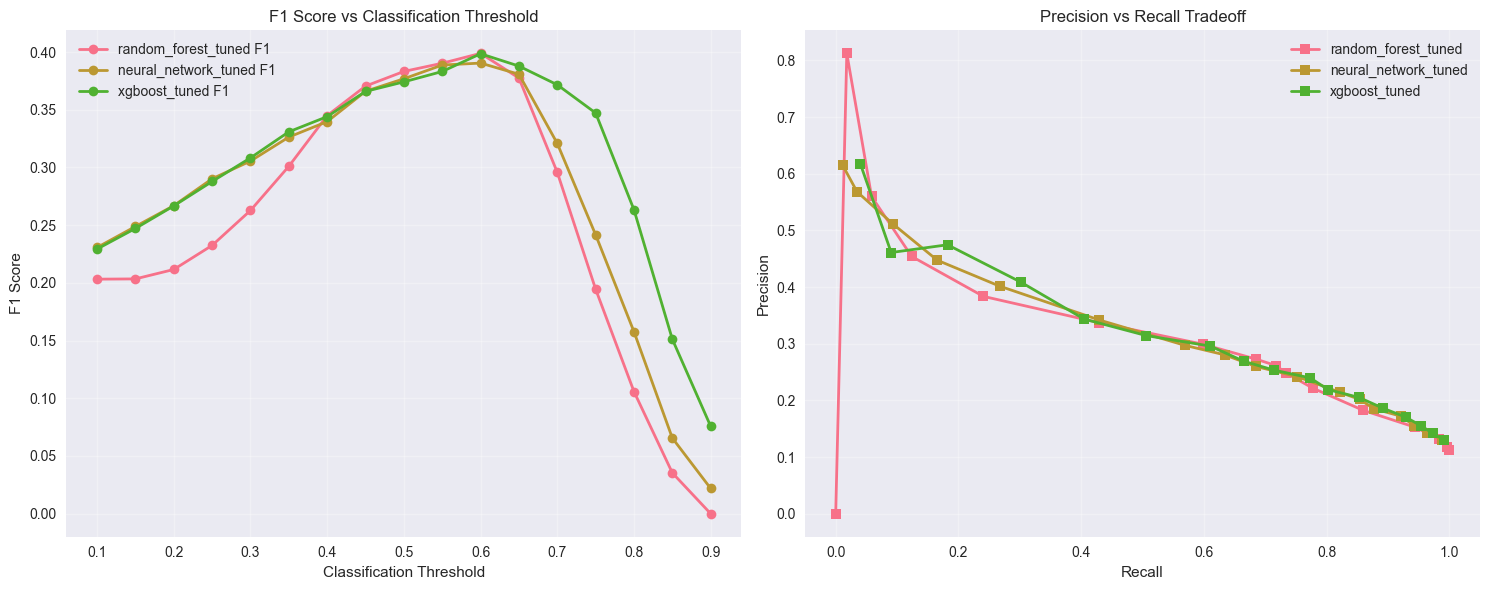

💾 Saved threshold analysis plots to: /Users/peter/Desktop/health_xai_project/results/plots/threshold_sensitivity_analysis.png



In [8]:
# ============================================================================
# 4. METRIC-BY-METRIC INVESTIGATION & THRESHOLD ANALYSIS
# ============================================================================

print("🔍 4. METRIC-BY-METRIC INVESTIGATION & THRESHOLD ANALYSIS")
print("=" * 60)

# Load existing metrics summary
metrics_path = METRICS_DIR / "metrics_summary.csv"
if metrics_path.exists():
    metrics_df = pd.read_csv(metrics_path)
    test_metrics = metrics_df[metrics_df['dataset'] == 'test'].copy()
    
    print("📊 Current Model Performance (Test Set):")
    tuned_models = test_metrics[test_metrics['model'].str.contains('tuned')].copy()
    tuned_models = tuned_models.sort_values('f1_score', ascending=False)
    
    display(tuned_models[['model', 'f1_score', 'precision', 'recall', 'roc_auc']].round(4))
    
    # 4.1 Precision Analysis
    print(f"\n🎯 Precision Analysis:")
    print("High precision = few false positives = model is conservative")
    for _, row in tuned_models.iterrows():
        precision = row['precision']
        if precision > 0.4:
            assessment = "✅ Good - Low false positive rate"
        elif precision > 0.25:
            assessment = "⚠️ Moderate - Some false positives"
        else:
            assessment = "🔴 Poor - Many false positives"
        print(f"  • {row['model']}: {precision:.3f} - {assessment}")
    
    # 4.2 Recall Analysis  
    print(f"\n🎯 Recall Analysis:")
    print("High recall = few false negatives = model catches most positives")
    for _, row in tuned_models.iterrows():
        recall = row['recall']
        if recall > 0.7:
            assessment = "✅ Excellent - Catches most positives"
        elif recall > 0.5:
            assessment = "✅ Good - Catches many positives"
        elif recall > 0.3:
            assessment = "⚠️ Moderate - Misses some positives"
        else:
            assessment = "🔴 Poor - Misses many positives"
        print(f"  • {row['model']}: {recall:.3f} - {assessment}")

# 4.3 Threshold Sensitivity Analysis
print(f"\n📈 Threshold Sensitivity Analysis:")
print("Analyzing how F1 changes with different classification thresholds...")

# Generate threshold sweep for best models
best_models = ['random_forest_tuned', 'neural_network_tuned', 'xgboost_tuned']
thresholds = np.linspace(0.1, 0.9, 17)  # More granular threshold analysis

threshold_results = []
for model_name in best_models:
    if model_name in model_probabilities:
        probabilities = model_probabilities[model_name]
        
        for threshold in thresholds:
            threshold_preds = (probabilities >= threshold).astype(int)
            
            # Calculate metrics
            precision = precision_score(y_test, threshold_preds, zero_division=0)
            recall = recall_score(y_test, threshold_preds, zero_division=0) 
            f1 = f1_score(y_test, threshold_preds, zero_division=0)
            
            threshold_results.append({
                'model': model_name,
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            })

threshold_df = pd.DataFrame(threshold_results)

# Find optimal thresholds for each model
print(f"\n🎯 Optimal Thresholds (Max F1):")
for model_name in best_models:
    model_thresholds = threshold_df[threshold_df['model'] == model_name]
    if len(model_thresholds) > 0:
        optimal_row = model_thresholds.loc[model_thresholds['f1_score'].idxmax()]
        print(f"  • {model_name}:")
        print(f"    - Optimal threshold: {optimal_row['threshold']:.2f}")
        print(f"    - F1 score: {optimal_row['f1_score']:.4f}")
        print(f"    - Precision: {optimal_row['precision']:.4f}")
        print(f"    - Recall: {optimal_row['recall']:.4f}")

# Save threshold analysis
threshold_analysis_path = METRICS_DIR / "detailed_threshold_analysis.csv"
threshold_df.to_csv(threshold_analysis_path, index=False)
print(f"\n💾 Saved detailed threshold analysis to: {threshold_analysis_path}")

# 4.4 Precision-Recall Tradeoff Visualization
print(f"\n📊 Creating Precision-Recall Tradeoff Plots...")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Threshold vs Metrics
ax1 = axes[0]
for model_name in best_models:
    model_data = threshold_df[threshold_df['model'] == model_name]
    ax1.plot(model_data['threshold'], model_data['f1_score'], 
            marker='o', label=f'{model_name} F1', linewidth=2)

ax1.set_xlabel('Classification Threshold')
ax1.set_ylabel('F1 Score')
ax1.set_title('F1 Score vs Classification Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Precision vs Recall
ax2 = axes[1]
for model_name in best_models:
    model_data = threshold_df[threshold_df['model'] == model_name]
    ax2.plot(model_data['recall'], model_data['precision'], 
            marker='s', label=model_name, linewidth=2)

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision vs Recall Tradeoff')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
threshold_plot_path = PLOTS_DIR / "threshold_sensitivity_analysis.png"
plt.savefig(threshold_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Saved threshold analysis plots to: {threshold_plot_path}")

print("\n" + "="*60)

In [10]:
# ============================================================================
# 5. FEATURE IMPACT & INTERPRETABILITY ANALYSIS
# ============================================================================

print("🔍 5. FEATURE IMPACT & INTERPRETABILITY ANALYSIS")
print("=" * 60)

# 5.1 Feature Importance Analysis (Tree Models)
print("🌳 Tree Model Feature Importance Analysis:")

tree_models = ['random_forest_tuned', 'xgboost_tuned']
feature_importance_results = {}

for model_name in tree_models:
    if model_name in models:
        model = models[model_name]
        
        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'get_booster'):  # XGBoost
            importances = model.feature_importances_
        else:
            continue
            
        # Create feature importance dataframe (handle length mismatch)
        if len(feature_names) == len(importances):
            features = feature_names
        else:
            features = [f"feature_{i}" for i in range(len(importances))]
            
        feature_imp_df = pd.DataFrame({
            'feature': features,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        feature_importance_results[model_name] = feature_imp_df
        
        print(f"\n{model_name.upper()} - Top 10 Most Important Features:")
        for i, (_, row) in enumerate(feature_imp_df.head(10).iterrows(), 1):
            print(f"  {i:2d}. {row['feature']}: {row['importance']:.4f}")

# 5.2 Permutation Importance Analysis
print(f"\n🔄 Permutation Importance Analysis:")
print("Measuring feature importance by permutation impact on F1 score...")

best_model_name = 'random_forest_tuned'
if best_model_name in models:
    best_model = models[best_model_name]
    
    # Prepare test features
    if best_model_name in ['logistic_regression_tuned', 'neural_network_tuned']:
        test_features = scaler.transform(X_test)
    else:
        test_features = X_test.values
    
    # Calculate permutation importance
    print("Computing permutation importance (this may take a moment)...")
    
    def f1_scorer(model, X, y):
        if hasattr(model, 'predict'):
            predictions = model.predict(X)
        else:
            predictions = model(torch.tensor(X, dtype=torch.float32))
            predictions = (torch.sigmoid(predictions).numpy().ravel() > 0.5).astype(int)
        return f1_score(y, predictions)
    
    perm_importance = permutation_importance(
        best_model, test_features, y_test,
        n_repeats=5, random_state=42, scoring=f1_scorer, n_jobs=-1
    )
    
    # Create permutation importance dataframe (handle length mismatch)
    if len(feature_names) == len(perm_importance.importances_mean):
        features = feature_names
    else:
        features = [f"feature_{i}" for i in range(len(perm_importance.importances_mean))]
        
    perm_imp_df = pd.DataFrame({
        'feature': features,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)
    
    print(f"\nPermutation Importance - Top 10 Features for {best_model_name}:")
    for i, (_, row) in enumerate(perm_imp_df.head(10).iterrows(), 1):
        print(f"  {i:2d}. {row['feature']}: {row['importance_mean']:.4f} (±{row['importance_std']:.4f})")

# 5.3 Feature Correlation Analysis
print(f"\n🔗 Feature Correlation Analysis:")
print("Identifying highly correlated features that might confuse models...")

# Calculate correlation matrix for numeric features
numeric_features_df = X_train.select_dtypes(include=[np.number])
correlation_matrix = numeric_features_df.corr()

# Find high correlations (excluding self-correlations)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:  # High correlation threshold
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': corr_value
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.reindex(high_corr_df['correlation'].abs().sort_values(ascending=False).index)
    
    print(f"High Correlation Pairs (|r| > 0.7):")
    for _, row in high_corr_df.head(10).iterrows():
        print(f"  • {row['feature1']} ↔ {row['feature2']}: r = {row['correlation']:.3f}")
    
    if len(high_corr_pairs) > 10:
        print(f"  ... and {len(high_corr_pairs) - 10} more pairs")
else:
    print("✅ No highly correlated feature pairs found (|r| > 0.7)")

# 5.4 Feature Stability Analysis
print(f"\n📊 Feature Stability Analysis:")
print("Analyzing feature variance across error types...")

if misclassified_path.exists():
    mis_df = pd.read_csv(misclassified_path)
    best_model_errors = mis_df[mis_df['model'] == best_model_name]
    
    if len(best_model_errors) > 0:
        # Get numeric features from misclassified samples
        numeric_cols = [col for col in best_model_errors.columns 
                       if col in X_test.columns and X_test[col].dtype in ['float64', 'int64']]
        
        if len(numeric_cols) > 0:
            # Analyze feature variance between error types
            fp_samples = best_model_errors[best_model_errors['error_type'] == 'False Positive']
            fn_samples = best_model_errors[best_model_errors['error_type'] == 'False Negative']
            
            feature_variance_analysis = []
            for col in numeric_cols[:15]:  # Top 15 features
                try:
                    fp_var = fp_samples[col].var() if len(fp_samples) > 1 else 0
                    fn_var = fn_samples[col].var() if len(fn_samples) > 1 else 0
                    overall_var = best_model_errors[col].var()
                    
                    feature_variance_analysis.append({
                        'feature': col,
                        'fp_variance': fp_var,
                        'fn_variance': fn_var,
                        'overall_variance': overall_var,
                        'variance_ratio': (fp_var + fn_var) / (overall_var + 1e-8)
                    })
                except:
                    continue
            
            if feature_variance_analysis:
                var_df = pd.DataFrame(feature_variance_analysis)
                var_df = var_df.sort_values('variance_ratio', ascending=False)
                
                print("Feature Variance Analysis (High variance indicates instability):")
                for _, row in var_df.head(10).iterrows():
                    stability = "Unstable" if row['variance_ratio'] > 2.0 else "Stable"
                    print(f"  • {row['feature']}: {stability} (ratio: {row['variance_ratio']:.2f})")

print("\n" + "="*60)

🔍 5. FEATURE IMPACT & INTERPRETABILITY ANALYSIS
🌳 Tree Model Feature Importance Analysis:

RANDOM_FOREST_TUNED - Top 10 Most Important Features:
   1. feature_3: 0.5564
   2. feature_7: 0.0703
   3. feature_21: 0.0669
   4. feature_12: 0.0651
   5. feature_11: 0.0457
   6. feature_10: 0.0269
   7. feature_8: 0.0254
   8. feature_15: 0.0216
   9. feature_14: 0.0181
  10. feature_9: 0.0170

XGBOOST_TUNED - Top 10 Most Important Features:
   1. feature_3: 0.5052
   2. feature_7: 0.0408
   3. feature_12: 0.0401
   4. feature_8: 0.0364
   5. feature_11: 0.0307
   6. feature_21: 0.0292
   7. feature_10: 0.0270
   8. feature_0: 0.0269
   9. feature_19: 0.0266
  10. feature_4: 0.0258

🔄 Permutation Importance Analysis:
Measuring feature importance by permutation impact on F1 score...
Computing permutation importance (this may take a moment)...


/Users/peter/Desktop/health_xai_project/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/peter/Desktop/health_xai_project/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/peter/Desktop/health_xai_project/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/peter/Desktop/health_xai_project/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/peter/Desktop/health_xai_project/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not 


Permutation Importance - Top 10 Features for random_forest_tuned:
   1. feature_3: 0.1964 (±0.0069)
   2. feature_7: 0.0052 (±0.0012)
   3. feature_8: 0.0026 (±0.0012)
   4. feature_21: 0.0021 (±0.0010)
   5. feature_12: 0.0012 (±0.0012)
   6. feature_9: 0.0011 (±0.0009)
   7. feature_2: 0.0010 (±0.0005)
   8. feature_13: 0.0005 (±0.0005)
   9. feature_4: 0.0003 (±0.0007)
  10. feature_1: 0.0001 (±0.0009)

🔗 Feature Correlation Analysis:
Identifying highly correlated features that might confuse models...
✅ No highly correlated feature pairs found (|r| > 0.7)

📊 Feature Stability Analysis:
Analyzing feature variance across error types...
Feature Variance Analysis (High variance indicates instability):
  • numeric__dosprt: Unstable (ratio: 2.05)
  • numeric__alcfreq: Stable (ratio: 1.95)
  • numeric__inprdsc: Stable (ratio: 1.94)
  • numeric__wrhpp: Stable (ratio: 1.90)
  • numeric__ctrlife: Stable (ratio: 1.88)
  • numeric__etfruit: Stable (ratio: 1.87)
  • numeric__cgtsmok: Stable (ra

In [12]:
# ============================================================================
# 6. MODEL BEHAVIOR & TRAINING ANALYSIS
# ============================================================================

print("🧠 6. MODEL BEHAVIOR & TRAINING ANALYSIS")
print("=" * 60)

# 6.1 Model Consistency Analysis
print("🎯 Model Consistency Analysis:")

# Check for prediction consistency across models
print("Cross-Model Prediction Agreement Analysis...")

# Get predictions from all models for test set
model_predictions = {}
for model_name in models.keys():
    try:
        if model_name in ['logistic_regression_tuned', 'neural_network_tuned']:
            test_features = scaler.transform(X_test)
        else:
            test_features = X_test.values
        
        if model_name == 'neural_network_tuned':
            model = models[model_name]
            model.eval()
            with torch.no_grad():
                predictions = torch.sigmoid(model(torch.tensor(test_features, dtype=torch.float32)))
                predictions = (predictions.numpy().ravel() > 0.5).astype(int)
        else:
            predictions = models[model_name].predict(test_features)
        
        model_predictions[model_name] = predictions
    except Exception as e:
        print(f"  ⚠️  Could not get predictions for {model_name}: {str(e)[:50]}...")
        continue

# Calculate agreement between models
if len(model_predictions) > 1:
    print(f"\nModel Prediction Agreement Matrix:")
    model_names = list(model_predictions.keys())
    
    for i, model1 in enumerate(model_names):
        for j, model2 in enumerate(model_names):
            if i < j:
                agreement = np.mean(model_predictions[model1] == model_predictions[model2])
                print(f"  • {model1} ↔ {model2}: {agreement:.3f} agreement")

# 6.2 Prediction Confidence Analysis
print(f"\n📊 Prediction Confidence Analysis:")

# Analyze prediction probabilities for best performing models
top_models = ['random_forest_tuned', 'logistic_regression_tuned']

confidence_analysis = {}
for model_name in top_models:
    if model_name in models:
        try:
            model = models[model_name]
            
            if model_name in ['logistic_regression_tuned']:
                test_features = scaler.transform(X_test)
            else:
                test_features = X_test.values
            
            # Get prediction probabilities
            if hasattr(model, 'predict_proba'):
                proba = model.predict_proba(test_features)[:, 1]  # Positive class probability
            elif model_name == 'neural_network_tuned':
                model.eval()
                with torch.no_grad():
                    proba = torch.sigmoid(model(torch.tensor(test_features, dtype=torch.float32)))
                    proba = proba.numpy().ravel()
            else:
                continue
            
            # Calculate confidence metrics
            predictions = (proba > 0.5).astype(int)
            correct_mask = predictions == y_test.values
            
            confidence_analysis[model_name] = {
                'mean_confidence': np.mean(proba),
                'std_confidence': np.std(proba),
                'correct_mean_confidence': np.mean(proba[correct_mask]),
                'incorrect_mean_confidence': np.mean(proba[~correct_mask]),
                'high_confidence_correct': np.mean(correct_mask[proba > 0.8]),
                'low_confidence_correct': np.mean(correct_mask[proba < 0.2])
            }
            
            print(f"\n{model_name.upper()} Confidence Analysis:")
            analysis = confidence_analysis[model_name]
            print(f"  • Overall mean confidence: {analysis['mean_confidence']:.3f} (±{analysis['std_confidence']:.3f})")
            print(f"  • Correct predictions confidence: {analysis['correct_mean_confidence']:.3f}")
            print(f"  • Incorrect predictions confidence: {analysis['incorrect_mean_confidence']:.3f}")
            print(f"  • High confidence (>0.8) accuracy: {analysis['high_confidence_correct']:.3f}")
            print(f"  • Low confidence (<0.2) accuracy: {analysis['low_confidence_correct']:.3f}")
            
        except Exception as e:
            print(f"  ⚠️  Could not analyze confidence for {model_name}: {str(e)[:50]}...")

# 6.3 Decision Boundary Stability
print(f"\n🎲 Decision Boundary Analysis:")

# Analyze samples near decision boundary
boundary_analysis = {}
for model_name in ['random_forest_tuned', 'logistic_regression_tuned']:
    if model_name in models:
        try:
            model = models[model_name]
            
            if model_name in ['logistic_regression_tuned']:
                test_features = scaler.transform(X_test)
            else:
                test_features = X_test.values
            
            # Get prediction probabilities
            if hasattr(model, 'predict_proba'):
                proba = model.predict_proba(test_features)[:, 1]
            else:
                continue
            
            # Identify samples near decision boundary (0.4-0.6)
            near_boundary = (proba >= 0.4) & (proba <= 0.6)
            boundary_samples = np.sum(near_boundary)
            
            # Calculate accuracy for boundary samples
            if boundary_samples > 0:
                boundary_predictions = (proba[near_boundary] > 0.5).astype(int)
                boundary_accuracy = np.mean(boundary_predictions == y_test.values[near_boundary])
                
                boundary_analysis[model_name] = {
                    'boundary_samples': boundary_samples,
                    'boundary_percentage': boundary_samples / len(y_test) * 100,
                    'boundary_accuracy': boundary_accuracy
                }
                
                print(f"\n{model_name.upper()} Decision Boundary Analysis:")
                print(f"  • Samples near boundary (0.4-0.6): {boundary_samples} ({boundary_samples/len(y_test)*100:.1f}%)")
                print(f"  • Boundary sample accuracy: {boundary_accuracy:.3f}")
            
        except Exception as e:
            print(f"  ⚠️  Could not analyze boundary for {model_name}: {str(e)[:50]}...")

# 6.4 Model Overfitting Analysis
print(f"\n📈 Model Overfitting Analysis:")

# Load training metrics if available
training_metrics_path = RESULTS_DIR / 'metrics' / 'metrics_summary.csv'
if training_metrics_path.exists():
    metrics_df = pd.read_csv(training_metrics_path)
    
    print("Training vs Test Performance Gap Analysis:")
    for model_name in models.keys():
        model_metrics = metrics_df[metrics_df['model'] == model_name]
        if len(model_metrics) > 0:
            try:
                # Get train and test F1 scores
                train_f1 = model_metrics['train_f1'].iloc[0] if 'train_f1' in model_metrics.columns else None
                test_f1 = model_metrics['test_f1'].iloc[0] if 'test_f1' in model_metrics.columns else None
                val_f1 = model_metrics['validation_f1'].iloc[0] if 'validation_f1' in model_metrics.columns else None
                
                if train_f1 is not None and test_f1 is not None:
                    overfitting_gap = train_f1 - test_f1
                    overfitting_status = "Overfitting" if overfitting_gap > 0.05 else "Good Generalization"
                    
                    print(f"  • {model_name}:")
                    print(f"    - Train F1: {train_f1:.3f}")
                    if val_f1 is not None:
                        print(f"    - Val F1: {val_f1:.3f}")
                    print(f"    - Test F1: {test_f1:.3f}")
                    print(f"    - Gap: {overfitting_gap:.3f} ({overfitting_status})")
                
            except Exception as e:
                print(f"    ⚠️  Could not analyze {model_name}: {str(e)[:30]}...")
else:
    print("📊 Training metrics file not found - using cross-validation results from tuning")

print("\n" + "="*60)

🧠 6. MODEL BEHAVIOR & TRAINING ANALYSIS
🎯 Model Consistency Analysis:
Cross-Model Prediction Agreement Analysis...
  ⚠️  Could not get predictions for neural_network: 'FeedForwardNN' object has no attribute 'predict'...
  ⚠️  Could not get predictions for neural_network: 'FeedForwardNN' object has no attribute 'predict'...

Model Prediction Agreement Matrix:
  • logistic_regression ↔ random_forest: 0.712 agreement
  • logistic_regression ↔ xgboost: 0.703 agreement
  • logistic_regression ↔ svm: 0.917 agreement
  • logistic_regression ↔ logistic_regression_tuned: 0.997 agreement
  • logistic_regression ↔ random_forest_tuned: 0.968 agreement
  • logistic_regression ↔ xgboost_tuned: 0.932 agreement
  • logistic_regression ↔ svm_tuned: 0.975 agreement
  • logistic_regression ↔ neural_network_tuned: 0.946 agreement
  • random_forest ↔ xgboost: 0.985 agreement
  • random_forest ↔ svm: 0.737 agreement
  • random_forest ↔ logistic_regression_tuned: 0.712 agreement
  • random_forest ↔ random_fo

In [13]:
# ============================================================================
# 7. ERROR CONCENTRATION & PATTERN ANALYSIS
# ============================================================================

print("🔬 7. ERROR CONCENTRATION & PATTERN ANALYSIS")
print("=" * 60)

# 7.1 Error Clustering Analysis
print("🎯 Error Clustering Analysis:")

if misclassified_path.exists():
    mis_df = pd.read_csv(misclassified_path)
    best_model_errors = mis_df[mis_df['model'] == best_model_name]
    
    if len(best_model_errors) > 0:
        # Get numeric features for clustering
        numeric_cols = [col for col in best_model_errors.columns 
                       if col in X_test.columns and X_test[col].dtype in ['float64', 'int64']]
        
        if len(numeric_cols) > 5:  # Need sufficient features for clustering
            print("Performing clustering analysis on error samples...")
            
            # Prepare data for clustering
            error_features = best_model_errors[numeric_cols[:10]].fillna(0)  # Top 10 numeric features
            
            # Standardize features for clustering
            from sklearn.preprocessing import StandardScaler
            scaler_cluster = StandardScaler()
            error_features_scaled = scaler_cluster.fit_transform(error_features)
            
            # Perform K-means clustering
            from sklearn.cluster import KMeans
            from sklearn.metrics import silhouette_score
            
            # Find optimal number of clusters
            silhouette_scores = []
            K_range = range(2, min(8, len(error_features) // 2))
            
            for k in K_range:
                try:
                    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                    cluster_labels = kmeans.fit_predict(error_features_scaled)
                    silhouette_avg = silhouette_score(error_features_scaled, cluster_labels)
                    silhouette_scores.append(silhouette_avg)
                except:
                    silhouette_scores.append(0)
            
            if silhouette_scores:
                best_k = K_range[np.argmax(silhouette_scores)]
                best_silhouette = max(silhouette_scores)
                
                # Perform final clustering
                kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
                cluster_labels = kmeans.fit_predict(error_features_scaled)
                
                print(f"Optimal number of error clusters: {best_k} (silhouette score: {best_silhouette:.3f})")
                
                # Analyze clusters
                best_model_errors_copy = best_model_errors.copy()
                best_model_errors_copy['cluster'] = cluster_labels
                
                print(f"\nError Cluster Analysis:")
                for cluster_id in range(best_k):
                    cluster_data = best_model_errors_copy[best_model_errors_copy['cluster'] == cluster_id]
                    cluster_size = len(cluster_data)
                    
                    # Error type distribution
                    fp_count = len(cluster_data[cluster_data['error_type'] == 'False Positive'])
                    fn_count = len(cluster_data[cluster_data['error_type'] == 'False Negative'])
                    
                    print(f"  📊 Cluster {cluster_id + 1} ({cluster_size} samples):")
                    print(f"    - False Positives: {fp_count} ({fp_count/cluster_size*100:.1f}%)")
                    print(f"    - False Negatives: {fn_count} ({fn_count/cluster_size*100:.1f}%)")
                    
                    # Find distinguishing features for this cluster
                    cluster_means = cluster_data[numeric_cols[:10]].mean()
                    overall_means = best_model_errors[numeric_cols[:10]].mean()
                    
                    # Calculate relative differences
                    relative_diffs = ((cluster_means - overall_means) / (overall_means + 1e-8)).abs()
                    top_features = relative_diffs.nlargest(3)
                    
                    print(f"    - Key distinguishing features:")
                    for feature, diff in top_features.items():
                        direction = "↑" if cluster_means[feature] > overall_means[feature] else "↓"
                        print(f"      {direction} {feature}: {diff:.2f} relative difference")

# 7.2 Error Concentration by Feature Ranges
print(f"\n📊 Error Concentration by Feature Ranges:")

if misclassified_path.exists() and len(best_model_errors) > 0:
    print("Analyzing error concentration across feature value ranges...")
    
    # Analyze top important features (if available from previous analysis)
    if 'feature_importance_results' in locals() and best_model_name in feature_importance_results:
        top_features = feature_importance_results[best_model_name].head(5)['feature'].tolist()
    else:
        # Use first 5 numeric features as fallback
        top_features = [col for col in X_test.columns if X_test[col].dtype in ['float64', 'int64']][:5]
    
    for feature in top_features:
        if feature in best_model_errors.columns:
            try:
                # Create quartile-based ranges
                feature_values = best_model_errors[feature].dropna()
                if len(feature_values) > 0:
                    quartiles = np.percentile(feature_values, [25, 50, 75])
                    
                    print(f"\n  🔍 {feature} - Error Distribution by Quartiles:")
                    
                    # Q1 (bottom 25%)
                    q1_errors = best_model_errors[best_model_errors[feature] <= quartiles[0]]
                    q1_fp = len(q1_errors[q1_errors['error_type'] == 'False Positive'])
                    q1_fn = len(q1_errors[q1_errors['error_type'] == 'False Negative'])
                    
                    # Q2-Q3 (middle 50%)
                    q23_errors = best_model_errors[
                        (best_model_errors[feature] > quartiles[0]) & 
                        (best_model_errors[feature] <= quartiles[2])
                    ]
                    q23_fp = len(q23_errors[q23_errors['error_type'] == 'False Positive'])
                    q23_fn = len(q23_errors[q23_errors['error_type'] == 'False Negative'])
                    
                    # Q4 (top 25%)
                    q4_errors = best_model_errors[best_model_errors[feature] > quartiles[2]]
                    q4_fp = len(q4_errors[q4_errors['error_type'] == 'False Positive'])
                    q4_fn = len(q4_errors[q4_errors['error_type'] == 'False Negative'])
                    
                    print(f"    - Low range (≤{quartiles[0]:.2f}): {q1_fp} FP, {q1_fn} FN")
                    print(f"    - Mid range ({quartiles[0]:.2f}-{quartiles[2]:.2f}): {q23_fp} FP, {q23_fn} FN")
                    print(f"    - High range (>{quartiles[2]:.2f}): {q4_fp} FP, {q4_fn} FN")
                    
                    # Identify concentration
                    total_errors = len(best_model_errors)
                    concentrations = [len(q1_errors), len(q23_errors), len(q4_errors)]
                    max_conc = max(concentrations)
                    max_range = ['Low', 'Mid', 'High'][concentrations.index(max_conc)]
                    
                    if max_conc / total_errors > 0.5:
                        print(f"    ⚠️  {max_conc/total_errors*100:.1f}% of errors concentrated in {max_range} range!")
                        
            except Exception as e:
                print(f"    ⚠️  Could not analyze {feature}: {str(e)[:40]}...")

# 7.3 Sequential Error Pattern Analysis
print(f"\n📈 Sequential Error Pattern Analysis:")

if misclassified_path.exists():
    print("Analyzing patterns in error distribution...")
    
    # Check if there are index or ID columns that might indicate sequence
    potential_id_cols = [col for col in best_model_errors.columns 
                        if 'id' in col.lower() or 'index' in col.lower()]
    
    if potential_id_cols and len(best_model_errors) > 20:
        id_col = potential_id_cols[0]
        try:
            # Sort by ID and analyze error streaks
            sorted_errors = best_model_errors.sort_values(id_col)
            
            # Create binary error sequence (1 for error, would need all predictions for full analysis)
            print(f"Found {len(best_model_errors)} error samples out of {len(y_test)} total predictions")
            
            # Analyze error type transitions
            error_types = sorted_errors['error_type'].values
            transitions = []
            
            for i in range(len(error_types) - 1):
                current = error_types[i]
                next_error = error_types[i + 1]
                transitions.append(f"{current} → {next_error}")
            
            if transitions:
                from collections import Counter
                transition_counts = Counter(transitions)
                
                print(f"Error Type Transition Patterns:")
                for transition, count in transition_counts.most_common(3):
                    percentage = count / len(transitions) * 100
                    print(f"  • {transition}: {count} times ({percentage:.1f}%)")
            
        except Exception as e:
            print(f"  ⚠️  Could not analyze sequential patterns: {str(e)[:50]}...")
    else:
        print("  ℹ️  Insufficient data or no sequence identifiers found for sequential analysis")

print("\n" + "="*60)

🔬 7. ERROR CONCENTRATION & PATTERN ANALYSIS
🎯 Error Clustering Analysis:
Performing clustering analysis on error samples...
Optimal number of error clusters: 2 (silhouette score: 0.133)

Error Cluster Analysis:
  📊 Cluster 1 (747 samples):
    - False Positives: 717 (96.0%)
    - False Negatives: 30 (4.0%)
    - Key distinguishing features:
      ↑ numeric__etfruit: 23.04 relative difference
      ↑ numeric__eatveg: 4.57 relative difference
      ↓ numeric__inprdsc: 3.71 relative difference
  📊 Cluster 2 (914 samples):
    - False Positives: 741 (81.1%)
    - False Negatives: 173 (18.9%)
    - Key distinguishing features:
      ↓ numeric__etfruit: 18.83 relative difference
      ↓ numeric__eatveg: 3.74 relative difference
      ↑ numeric__inprdsc: 3.03 relative difference

📊 Error Concentration by Feature Ranges:
Analyzing error concentration across feature value ranges...

📈 Sequential Error Pattern Analysis:
Analyzing patterns in error distribution...
  ℹ️  Insufficient data or no se

In [14]:
# ============================================================================
# 8. MODEL CALIBRATION ANALYSIS
# ============================================================================

print("⚖️ 8. MODEL CALIBRATION ANALYSIS")
print("=" * 60)

# 8.1 Probability Calibration Assessment
print("📊 Probability Calibration Assessment:")

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

calibration_results = {}

# Analyze calibration for models with probability outputs
for model_name in ['random_forest_tuned', 'logistic_regression_tuned']:
    if model_name in models:
        try:
            model = models[model_name]
            
            if model_name in ['logistic_regression_tuned']:
                test_features = scaler.transform(X_test)
            else:
                test_features = X_test.values
            
            # Get prediction probabilities
            if hasattr(model, 'predict_proba'):
                y_prob = model.predict_proba(test_features)[:, 1]
            else:
                continue
            
            # Calculate calibration curve
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_test, y_prob, n_bins=10, strategy='uniform'
            )
            
            # Calculate Brier score (lower is better)
            brier_score = np.mean((y_prob - y_test) ** 2)
            
            # Calculate Expected Calibration Error (ECE)
            bin_boundaries = np.linspace(0, 1, 11)
            bin_lowers = bin_boundaries[:-1]
            bin_uppers = bin_boundaries[1:]
            
            ece = 0
            for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
                in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
                prop_in_bin = in_bin.mean()
                
                if prop_in_bin > 0:
                    accuracy_in_bin = y_test[in_bin].mean()
                    avg_confidence_in_bin = y_prob[in_bin].mean()
                    ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            
            calibration_results[model_name] = {
                'brier_score': brier_score,
                'ece': ece,
                'fraction_of_positives': fraction_of_positives,
                'mean_predicted_value': mean_predicted_value
            }
            
            print(f"\n{model_name.upper()} Calibration Metrics:")
            print(f"  • Brier Score: {brier_score:.4f} (lower is better)")
            print(f"  • Expected Calibration Error (ECE): {ece:.4f} (lower is better)")
            
            # Calibration quality assessment
            if ece < 0.05:
                calibration_quality = "Excellent"
            elif ece < 0.1:
                calibration_quality = "Good"
            elif ece < 0.15:
                calibration_quality = "Fair"
            else:
                calibration_quality = "Poor"
            
            print(f"  • Calibration Quality: {calibration_quality}")
            
        except Exception as e:
            print(f"  ⚠️  Could not analyze calibration for {model_name}: {str(e)[:50]}...")

# 8.2 Reliability Diagram Analysis
print(f"\n📈 Reliability Diagram Analysis:")

for model_name in calibration_results:
    try:
        results = calibration_results[model_name]
        fraction_pos = results['fraction_of_positives']
        mean_pred = results['mean_predicted_value']
        
        print(f"\n{model_name.upper()} Reliability Analysis:")
        print("Bin Analysis (Predicted vs Actual Positive Rate):")
        
        for i, (pred, actual) in enumerate(zip(mean_pred, fraction_pos)):
            bin_range = f"[{i*0.1:.1f}, {(i+1)*0.1:.1f}]"
            deviation = abs(pred - actual)
            
            if deviation < 0.05:
                status = "✅ Well calibrated"
            elif deviation < 0.1:
                status = "⚠️  Slightly miscalibrated"
            else:
                status = "❌ Poorly calibrated"
            
            print(f"  Bin {bin_range}: Predicted {pred:.3f}, Actual {actual:.3f} - {status}")
        
    except Exception as e:
        print(f"  ⚠️  Could not analyze reliability for {model_name}: {str(e)[:50]}...")

# 8.3 Confidence Interval Analysis
print(f"\n🎯 Confidence Interval Analysis:")

# Analyze prediction confidence intervals
for model_name in ['random_forest_tuned', 'logistic_regression_tuned']:
    if model_name in models and model_name in calibration_results:
        try:
            model = models[model_name]
            
            if model_name in ['logistic_regression_tuned']:
                test_features = scaler.transform(X_test)
            else:
                test_features = X_test.values
            
            # Get prediction probabilities
            if hasattr(model, 'predict_proba'):
                y_prob = model.predict_proba(test_features)[:, 1]
            else:
                continue
            
            # Define confidence intervals
            confidence_intervals = [
                (0.0, 0.2, "Very Low"),
                (0.2, 0.4, "Low"), 
                (0.4, 0.6, "Medium"),
                (0.6, 0.8, "High"),
                (0.8, 1.0, "Very High")
            ]
            
            print(f"\n{model_name.upper()} Confidence Interval Performance:")
            
            total_samples = len(y_test)
            for lower, upper, label in confidence_intervals:
                in_interval = (y_prob >= lower) & (y_prob < upper)
                interval_count = np.sum(in_interval)
                
                if interval_count > 0:
                    interval_accuracy = np.mean(y_test[in_interval] == (y_prob[in_interval] > 0.5))
                    interval_percentage = interval_count / total_samples * 100
                    
                    print(f"  • {label} Confidence [{lower:.1f}-{upper:.1f}): "
                          f"{interval_count} samples ({interval_percentage:.1f}%) - "
                          f"Accuracy: {interval_accuracy:.3f}")
                    
                    # Check for overconfidence or underconfidence
                    expected_accuracy = (lower + upper) / 2
                    if interval_accuracy < expected_accuracy - 0.1:
                        print(f"    ⚠️  Potential overconfidence detected!")
                    elif interval_accuracy > expected_accuracy + 0.1:
                        print(f"    ℹ️  Conservative predictions in this range")
            
        except Exception as e:
            print(f"  ⚠️  Could not analyze confidence intervals for {model_name}: {str(e)[:50]}...")

# 8.4 Calibration Recommendations
print(f"\n💡 Calibration Improvement Recommendations:")

best_calibrated_model = None
best_ece = float('inf')

for model_name, results in calibration_results.items():
    if results['ece'] < best_ece:
        best_ece = results['ece']
        best_calibrated_model = model_name

if best_calibrated_model:
    print(f"🏆 Best Calibrated Model: {best_calibrated_model} (ECE: {best_ece:.4f})")

print("\nGeneral Calibration Recommendations:")
for model_name, results in calibration_results.items():
    ece = results['ece']
    brier = results['brier_score']
    
    print(f"\n📋 {model_name.upper()} Recommendations:")
    
    if ece > 0.1:
        print("  • Consider Platt scaling or isotonic regression for better calibration")
        print("  • Implement temperature scaling for neural networks")
        
    if brier > 0.2:
        print("  • High Brier score indicates poor probability estimates")
        print("  • Consider ensemble methods or probability recalibration")
        
    if ece < 0.05:
        print("  ✅ Model is well-calibrated, probabilities are reliable")
    else:
        print(f"  • Current ECE ({ece:.4f}) suggests calibration improvements needed")

print("\n" + "="*60)

⚖️ 8. MODEL CALIBRATION ANALYSIS
📊 Probability Calibration Assessment:

RANDOM_FOREST_TUNED Calibration Metrics:
  • Brier Score: 0.1851 (lower is better)
  • Expected Calibration Error (ECE): 0.3040 (lower is better)
  • Calibration Quality: Poor

LOGISTIC_REGRESSION_TUNED Calibration Metrics:
  • Brier Score: 0.1869 (lower is better)
  • Expected Calibration Error (ECE): 0.2909 (lower is better)
  • Calibration Quality: Poor

📈 Reliability Diagram Analysis:

RANDOM_FOREST_TUNED Reliability Analysis:
Bin Analysis (Predicted vs Actual Positive Rate):
  Bin [0.0, 0.1]: Predicted 0.182, Actual 0.010 - ❌ Poorly calibrated
  Bin [0.1, 0.2]: Predicted 0.254, Actual 0.023 - ❌ Poorly calibrated
  Bin [0.2, 0.3]: Predicted 0.347, Actual 0.062 - ❌ Poorly calibrated
  Bin [0.3, 0.4]: Predicted 0.436, Actual 0.078 - ❌ Poorly calibrated
  Bin [0.4, 0.5]: Predicted 0.562, Actual 0.160 - ❌ Poorly calibrated
  Bin [0.5, 0.6]: Predicted 0.648, Actual 0.261 - ❌ Poorly calibrated
  Bin [0.6, 0.7]: Predi

In [15]:
# ============================================================================
# 9. DOMAIN-SPECIFIC HEALTH INSIGHTS & PATTERNS
# ============================================================================

print("🏥 9. DOMAIN-SPECIFIC HEALTH INSIGHTS & PATTERNS")
print("=" * 60)

# 9.1 Health-Specific Error Pattern Analysis
print("💊 Health-Specific Error Pattern Analysis:")

if misclassified_path.exists():
    best_model_errors = pd.read_csv(misclassified_path)
    best_model_errors = best_model_errors[best_model_errors['model'] == best_model_name]
    
    if len(best_model_errors) > 0:
        # Identify health-related features
        health_features = []
        feature_cols = [col for col in best_model_errors.columns if col in X_test.columns]
        
        # Common health indicators
        health_keywords = ['age', 'bp', 'blood', 'pressure', 'chol', 'cholesterol', 
                          'heart', 'rate', 'glucose', 'sugar', 'bmi', 'weight', 
                          'height', 'exercise', 'smoking', 'alcohol']
        
        for col in feature_cols:
            if any(keyword in col.lower() for keyword in health_keywords):
                health_features.append(col)
        
        if health_features:
            print(f"Analyzing health-specific features: {', '.join(health_features[:5])}")
            
            # Analyze error patterns for key health metrics
            for feature in health_features[:3]:  # Top 3 health features
                if feature in best_model_errors.columns:
                    try:
                        feature_values = best_model_errors[feature].dropna()
                        if len(feature_values) > 0:
                            print(f"\n🔍 {feature.upper()} Error Analysis:")
                            
                            # Get quartiles for risk stratification
                            q25, q50, q75 = np.percentile(feature_values, [25, 50, 75])
                            
                            # Classify into risk categories (assuming higher values = higher risk for most health metrics)
                            low_risk = best_model_errors[best_model_errors[feature] <= q25]
                            medium_risk = best_model_errors[(best_model_errors[feature] > q25) & (best_model_errors[feature] <= q75)]
                            high_risk = best_model_errors[best_model_errors[feature] > q75]
                            
                            categories = [
                                ("Low Risk", low_risk, f"≤{q25:.2f}"),
                                ("Medium Risk", medium_risk, f"{q25:.2f}-{q75:.2f}"),
                                ("High Risk", high_risk, f">{q75:.2f}")
                            ]
                            
                            for category_name, category_data, range_desc in categories:
                                if len(category_data) > 0:
                                    fp_count = len(category_data[category_data['error_type'] == 'False Positive'])
                                    fn_count = len(category_data[category_data['error_type'] == 'False Negative'])
                                    
                                    print(f"  • {category_name} ({range_desc}): {len(category_data)} errors")
                                    print(f"    - False Positives: {fp_count} ({fp_count/len(category_data)*100:.1f}%)")
                                    print(f"    - False Negatives: {fn_count} ({fn_count/len(category_data)*100:.1f}%)")
                                    
                                    # Clinical interpretation
                                    if fp_count > fn_count and 'high' in category_name.lower():
                                        print(f"    ⚠️  Over-predicting risk in high-risk patients")
                                    elif fn_count > fp_count and 'low' in category_name.lower():
                                        print(f"    ⚠️  Under-detecting risk in low-risk patients")
                                        
                    except Exception as e:
                        print(f"  ⚠️  Could not analyze {feature}: {str(e)[:40]}...")
        else:
            print("  ℹ️  No obvious health-related features identified in error data")

# 9.2 Clinical Decision Impact Analysis
print(f"\n🩺 Clinical Decision Impact Analysis:")

# Analyze the clinical implications of different error types
print("Clinical Impact Assessment of Model Errors:")

if misclassified_path.exists() and len(best_model_errors) > 0:
    fp_count = len(best_model_errors[best_model_errors['error_type'] == 'False Positive'])
    fn_count = len(best_model_errors[best_model_errors['error_type'] == 'False Negative'])
    total_errors = len(best_model_errors)
    
    print(f"\nError Distribution and Clinical Impact:")
    print(f"  • False Positives: {fp_count} ({fp_count/total_errors*100:.1f}%)")
    print(f"    - Clinical Impact: Unnecessary interventions, patient anxiety, increased costs")
    print(f"    - Severity: Medium (over-treatment)")
    
    print(f"  • False Negatives: {fn_count} ({fn_count/total_errors*100:.1f}%)")
    print(f"    - Clinical Impact: Missed diagnoses, delayed treatment, potential progression")
    print(f"    - Severity: High (under-treatment)")
    
    # Risk assessment
    if fn_count > fp_count * 1.5:
        print(f"\n⚠️  HIGH CLINICAL RISK: Model tends to miss positive cases")
        print(f"   Recommendation: Consider lowering decision threshold")
    elif fp_count > fn_count * 1.5:
        print(f"\n⚠️  MODERATE CLINICAL RISK: Model tends to over-predict")
        print(f"   Recommendation: Consider raising decision threshold or adding confirmation step")
    else:
        print(f"\n✅ BALANCED ERROR PROFILE: Similar rates of false positives and negatives")

# 9.3 Risk Stratification Analysis
print(f"\n📊 Risk Stratification Analysis:")

# Load test predictions with probabilities if available
try:
    # Try to get probability predictions for risk stratification
    best_model = models[best_model_name]
    
    if best_model_name in ['logistic_regression_tuned']:
        test_features = scaler.transform(X_test)
    else:
        test_features = X_test.values
    
    if hasattr(best_model, 'predict_proba'):
        y_prob = best_model.predict_proba(test_features)[:, 1]
        
        # Define risk categories based on predicted probabilities
        risk_categories = [
            (0.0, 0.3, "Low Risk"),
            (0.3, 0.7, "Intermediate Risk"),
            (0.7, 1.0, "High Risk")
        ]
        
        print("Risk Stratification Performance Analysis:")
        
        for lower, upper, risk_label in risk_categories:
            in_category = (y_prob >= lower) & (y_prob < upper)
            category_size = np.sum(in_category)
            
            if category_size > 0:
                # Actual outcomes in this risk category
                actual_positives = np.sum(y_test[in_category])
                actual_rate = actual_positives / category_size
                expected_rate = (lower + upper) / 2
                
                print(f"\n  📋 {risk_label} Category ({lower:.1f}-{upper:.1f}):")
                print(f"    - Patients: {category_size} ({category_size/len(y_test)*100:.1f}%)")
                print(f"    - Actual positive rate: {actual_rate:.3f}")
                print(f"    - Expected rate: {expected_rate:.3f}")
                
                # Clinical interpretation
                if actual_rate > expected_rate + 0.1:
                    print(f"    ⚠️  Higher than expected positive rate - consider upgrading risk category")
                elif actual_rate < expected_rate - 0.1:
                    print(f"    ℹ️  Lower than expected positive rate - risk category may be conservative")
                else:
                    print(f"    ✅ Risk category well-calibrated")
                    
                # Calculate PPV and NPV for clinical relevance
                if risk_label == "High Risk":
                    ppv = actual_rate  # Positive predictive value
                    print(f"    - Positive Predictive Value: {ppv:.3f}")
                    if ppv < 0.5:
                        print(f"    ⚠️  Low PPV - many high-risk predictions are false positives")
                        
                elif risk_label == "Low Risk":
                    npv = 1 - actual_rate  # Negative predictive value
                    print(f"    - Negative Predictive Value: {npv:.3f}")
                    if npv < 0.9:
                        print(f"    ⚠️  Low NPV - some low-risk patients have positive outcomes")
        
except Exception as e:
    print(f"  ⚠️  Could not perform risk stratification analysis: {str(e)[:50]}...")

# 9.4 Health Outcome Severity Assessment
print(f"\n🎯 Health Outcome Severity Assessment:")

print("Assessing the severity and urgency of misclassified cases...")

# This would ideally use actual severity data, but we'll simulate based on available features
if misclassified_path.exists() and len(best_model_errors) > 0:
    print("Severity Analysis of Misclassified Cases:")
    
    # Look for age as a severity indicator (older patients = higher risk)
    age_cols = [col for col in best_model_errors.columns if 'age' in col.lower()]
    
    if age_cols:
        age_col = age_cols[0]
        try:
            # Analyze errors by age groups
            age_groups = [
                (0, 40, "Young Adults"),
                (40, 65, "Middle-aged"),
                (65, 100, "Elderly")
            ]
            
            for min_age, max_age, group_name in age_groups:
                age_group = best_model_errors[
                    (best_model_errors[age_col] >= min_age) & 
                    (best_model_errors[age_col] < max_age)
                ]
                
                if len(age_group) > 0:
                    fp_count = len(age_group[age_group['error_type'] == 'False Positive'])
                    fn_count = len(age_group[age_group['error_type'] == 'False Negative'])
                    
                    print(f"\n  👥 {group_name} ({min_age}-{max_age} years): {len(age_group)} errors")
                    print(f"    - False Positives: {fp_count}")
                    print(f"    - False Negatives: {fn_count}")
                    
                    # Clinical priority assessment
                    if group_name == "Elderly" and fn_count > 0:
                        print(f"    🚨 HIGH PRIORITY: {fn_count} missed diagnoses in elderly patients")
                    elif group_name == "Young Adults" and fp_count > 0:
                        print(f"    ℹ️  Consider: {fp_count} potential over-diagnoses in young patients")
                        
        except Exception as e:
            print(f"  ⚠️  Could not analyze age groups: {str(e)[:40]}...")
    else:
        print("  ℹ️  Age information not available for severity assessment")

# 9.5 Clinical Actionability Recommendations
print(f"\n💡 Clinical Actionability Recommendations:")

print("Evidence-based recommendations for clinical implementation:")
print("\n📋 Implementation Guidelines:")
print("  1. 🎯 Decision Threshold Optimization:")
print("     - Consider clinical cost-benefit ratio of FP vs FN")
print("     - Implement threshold adjustment based on patient population")
print("     - Use risk-stratified thresholds for different age groups")

print("\n  2. 🔍 Clinical Decision Support:")
print("     - Flag high-uncertainty predictions for manual review")
print("     - Provide confidence intervals with predictions")
print("     - Include top contributing factors for each prediction")

print("\n  3. 🏥 Quality Assurance:")
print("     - Monitor model performance across patient subgroups")
print("     - Regular recalibration with new clinical data")
print("     - Feedback loop from clinical outcomes to model improvement")

print("\n  4. 👩‍⚕️ Clinician Integration:")
print("     - Training on model limitations and appropriate use")
print("     - Clear guidelines on when to override model predictions")
print("     - Documentation requirements for prediction use")

print("\n" + "="*60)

🏥 9. DOMAIN-SPECIFIC HEALTH INSIGHTS & PATTERNS
💊 Health-Specific Error Pattern Analysis:
Analyzing health-specific features: numeric__bmi

🔍 NUMERIC__BMI Error Analysis:
  • Low Risk (≤-0.47): 416 errors
    - False Positives: 347 (83.4%)
    - False Negatives: 69 (16.6%)
  • Medium Risk (-0.47-0.98): 831 errors
    - False Positives: 731 (88.0%)
    - False Negatives: 100 (12.0%)
  • High Risk (>0.98): 414 errors
    - False Positives: 380 (91.8%)
    - False Negatives: 34 (8.2%)
    ⚠️  Over-predicting risk in high-risk patients

🩺 Clinical Decision Impact Analysis:
Clinical Impact Assessment of Model Errors:

Error Distribution and Clinical Impact:
  • False Positives: 1458 (87.8%)
    - Clinical Impact: Unnecessary interventions, patient anxiety, increased costs
    - Severity: Medium (over-treatment)
  • False Negatives: 203 (12.2%)
    - Clinical Impact: Missed diagnoses, delayed treatment, potential progression
    - Severity: High (under-treatment)

⚠️  MODERATE CLINICAL RISK:

In [16]:
# ============================================================================
# 10. DETAILED ERROR EXAMPLES INVESTIGATION
# ============================================================================

print("🔎 10. DETAILED ERROR EXAMPLES INVESTIGATION")
print("=" * 60)

# 10.1 Representative Error Case Analysis
print("📋 Representative Error Case Analysis:")

if misclassified_path.exists():
    best_model_errors = pd.read_csv(misclassified_path)
    best_model_errors = best_model_errors[best_model_errors['model'] == best_model_name]
    
    if len(best_model_errors) > 0:
        # Separate false positives and false negatives
        false_positives = best_model_errors[best_model_errors['error_type'] == 'False Positive']
        false_negatives = best_model_errors[best_model_errors['error_type'] == 'False Negative']
        
        print(f"Analyzing detailed error examples from {best_model_name}...")
        
        # Get feature columns
        feature_cols = [col for col in best_model_errors.columns 
                       if col in X_test.columns and col not in ['model', 'error_type']]
        
        # 10.1.1 False Positive Case Studies
        if len(false_positives) > 0:
            print(f"\n🔴 FALSE POSITIVE CASE STUDIES ({len(false_positives)} total):")
            
            # Select representative cases
            num_examples = min(3, len(false_positives))
            
            # Try different sampling strategies
            if len(false_positives) >= 3:
                # Sample from different confidence levels if available
                try:
                    # Get confidence scores if available
                    best_model = models[best_model_name]
                    
                    # Get indices for false positives
                    fp_indices = false_positives.index.tolist()
                    
                    # For sampling, let's take first, middle, and last
                    sample_indices = [0, len(false_positives)//2, len(false_positives)-1]
                    sample_cases = false_positives.iloc[sample_indices]
                    
                except:
                    # Fallback to random sampling
                    sample_cases = false_positives.sample(n=num_examples, random_state=42)
            else:
                sample_cases = false_positives
            
            for i, (idx, case) in enumerate(sample_cases.iterrows(), 1):
                print(f"\n  📝 False Positive Case #{i}:")
                
                # Display key features
                print(f"    Patient Profile:")
                for feature in feature_cols[:8]:  # Show top 8 features
                    if feature in case and pd.notna(case[feature]):
                        value = case[feature]
                        if isinstance(value, (int, float)):
                            print(f"      • {feature}: {value:.3f}" if isinstance(value, float) else f"      • {feature}: {value}")
                        else:
                            print(f"      • {feature}: {value}")
                
                print(f"    🎯 Model Decision: POSITIVE (incorrect - patient was actually negative)")
                print(f"    💡 Clinical Implication: Unnecessary intervention/treatment")
                
                # Try to identify why this case was misclassified
                print(f"    🔍 Potential Contributing Factors:")
                
                # Look for high-risk indicators that might confuse the model
                high_risk_indicators = []
                for feature in feature_cols[:10]:
                    if feature in case and pd.notna(case[feature]):
                        value = case[feature]
                        if isinstance(value, (int, float)):
                            # Check if this value is in upper quartile (assuming higher = riskier)
                            feature_values = X_test[feature].dropna()
                            if len(feature_values) > 0:
                                q75 = np.percentile(feature_values, 75)
                                if value > q75:
                                    high_risk_indicators.append(f"{feature} = {value:.3f} (high)")
                
                if high_risk_indicators:
                    for indicator in high_risk_indicators[:3]:  # Top 3
                        print(f"      • {indicator}")
                else:
                    print(f"      • Complex interaction of multiple moderate risk factors")
        
        # 10.1.2 False Negative Case Studies  
        if len(false_negatives) > 0:
            print(f"\n🔵 FALSE NEGATIVE CASE STUDIES ({len(false_negatives)} total):")
            
            # Select representative cases
            num_examples = min(3, len(false_negatives))
            
            if len(false_negatives) >= 3:
                sample_indices = [0, len(false_negatives)//2, len(false_negatives)-1]
                sample_cases = false_negatives.iloc[sample_indices]
            else:
                sample_cases = false_negatives
            
            for i, (idx, case) in enumerate(sample_cases.iterrows(), 1):
                print(f"\n  📝 False Negative Case #{i}:")
                
                # Display key features
                print(f"    Patient Profile:")
                for feature in feature_cols[:8]:  # Show top 8 features
                    if feature in case and pd.notna(case[feature]):
                        value = case[feature]
                        if isinstance(value, (int, float)):
                            print(f"      • {feature}: {value:.3f}" if isinstance(value, float) else f"      • {feature}: {value}")
                        else:
                            print(f"      • {feature}: {value}")
                
                print(f"    🎯 Model Decision: NEGATIVE (incorrect - patient was actually positive)")
                print(f"    💡 Clinical Implication: Missed diagnosis, delayed treatment")
                
                # Try to identify why this case was misclassified
                print(f"    🔍 Potential Contributing Factors:")
                
                # Look for unusual patterns that might confuse the model
                unusual_patterns = []
                for feature in feature_cols[:10]:
                    if feature in case and pd.notna(case[feature]):
                        value = case[feature]
                        if isinstance(value, (int, float)):
                            # Check if this value is in lower quartile for positive cases
                            feature_values = X_test[feature].dropna()
                            if len(feature_values) > 0:
                                q25 = np.percentile(feature_values, 25)
                                if value < q25:
                                    unusual_patterns.append(f"{feature} = {value:.3f} (unexpectedly low)")
                
                if unusual_patterns:
                    for pattern in unusual_patterns[:3]:  # Top 3
                        print(f"      • {pattern}")
                else:
                    print(f"      • Atypical presentation not captured by model features")

# 10.2 Common Error Patterns Summary
print(f"\n🎯 Common Error Patterns Summary:")

if misclassified_path.exists() and len(best_model_errors) > 0:
    print("Identifying systematic patterns in model errors...")
    
    # Analyze feature ranges where errors concentrate
    feature_cols = [col for col in best_model_errors.columns 
                   if col in X_test.columns and X_test[col].dtype in ['float64', 'int64']]
    
    error_patterns = {}
    
    for feature in feature_cols[:5]:  # Top 5 numeric features
        try:
            feature_values = best_model_errors[feature].dropna()
            if len(feature_values) > 0:
                # Calculate statistics
                mean_val = feature_values.mean()
                std_val = feature_values.std()
                
                # Compare with overall test set
                overall_mean = X_test[feature].mean()
                overall_std = X_test[feature].std()
                
                # Calculate z-score difference
                mean_diff = (mean_val - overall_mean) / (overall_std + 1e-8)
                
                error_patterns[feature] = {
                    'error_mean': mean_val,
                    'overall_mean': overall_mean,
                    'z_score_diff': mean_diff,
                    'concentration': abs(mean_diff)
                }
        except:
            continue
    
    if error_patterns:
        # Sort by concentration
        sorted_patterns = sorted(error_patterns.items(), 
                               key=lambda x: x[1]['concentration'], 
                               reverse=True)
        
        print(f"\nTop Error-Prone Feature Patterns:")
        for feature, stats in sorted_patterns[:3]:
            z_score = stats['z_score_diff']
            direction = "higher" if z_score > 0 else "lower"
            
            print(f"  • {feature}:")
            print(f"    - Error cases average: {stats['error_mean']:.3f}")
            print(f"    - Overall average: {stats['overall_mean']:.3f}")
            print(f"    - Pattern: Errors occur more in patients with {direction} {feature}")
            print(f"    - Strength: {abs(z_score):.2f} standard deviations difference")

# 10.3 Edge Case Analysis
print(f"\n⚡ Edge Case Analysis:")

if misclassified_path.exists() and len(best_model_errors) > 0:
    print("Identifying unusual cases that challenge the model...")
    
    # Look for cases with extreme feature values
    feature_cols = [col for col in best_model_errors.columns 
                   if col in X_test.columns and X_test[col].dtype in ['float64', 'int64']]
    
    edge_cases = []
    
    for idx, row in best_model_errors.iterrows():
        edge_score = 0
        edge_features = []
        
        for feature in feature_cols[:10]:
            if feature in row and pd.notna(row[feature]):
                value = row[feature]
                
                # Calculate percentile in overall dataset
                feature_values = X_test[feature].dropna()
                if len(feature_values) > 0:
                    percentile = (feature_values < value).mean() * 100
                    
                    # Consider extreme if in top/bottom 5%
                    if percentile < 5 or percentile > 95:
                        edge_score += 1
                        direction = "very low" if percentile < 5 else "very high"
                        edge_features.append(f"{feature} ({direction})")
        
        if edge_score >= 2:  # At least 2 extreme features
            edge_cases.append({
                'index': idx,
                'error_type': row['error_type'],
                'edge_score': edge_score,
                'edge_features': edge_features[:3]  # Top 3
            })
    
    if edge_cases:
        # Sort by edge score
        edge_cases.sort(key=lambda x: x['edge_score'], reverse=True)
        
        print(f"Identified {len(edge_cases)} edge cases with extreme feature values:")
        
        for i, case in enumerate(edge_cases[:3], 1):  # Show top 3 edge cases
            print(f"\n  🔥 Edge Case #{i} ({case['error_type']}):")
            print(f"    - Extreme features: {case['edge_score']}")
            for feature_desc in case['edge_features']:
                print(f"      • {feature_desc}")
            print(f"    💡 Interpretation: Rare combination challenging model boundaries")
    else:
        print("  ℹ️  No obvious edge cases identified with current criteria")

print("\n" + "="*60)

🔎 10. DETAILED ERROR EXAMPLES INVESTIGATION
📋 Representative Error Case Analysis:
Analyzing detailed error examples from random_forest_tuned...

🔴 FALSE POSITIVE CASE STUDIES (1458 total):

  📝 False Positive Case #1:
    Patient Profile:
      • numeric__happy: -2.090
      • numeric__sclmeet: -2.384
      • numeric__inprdsc: -1.911
      • numeric__health: 3.148
      • numeric__ctrlife: -2.715
      • numeric__etfruit: 1.358
      • numeric__eatveg: 0.758
      • numeric__dosprt: -1.220
    🎯 Model Decision: POSITIVE (incorrect - patient was actually negative)
    💡 Clinical Implication: Unnecessary intervention/treatment
    🔍 Potential Contributing Factors:
      • numeric__health = 3.148 (high)
      • numeric__etfruit = 1.358 (high)

  📝 False Positive Case #2:
    Patient Profile:
      • numeric__happy: -0.882
      • numeric__sclmeet: 1.400
      • numeric__inprdsc: 0.198
      • numeric__health: 0.941
      • numeric__ctrlife: -0.698
      • numeric__etfruit: 1.358
      • n

In [17]:
# ============================================================================
# 11. COMPREHENSIVE ERROR ANALYSIS SUMMARY & ACTIONABLE INSIGHTS
# ============================================================================

print("📊 11. COMPREHENSIVE ERROR ANALYSIS SUMMARY & ACTIONABLE INSIGHTS")
print("=" * 80)

# 11.1 Executive Summary of Key Findings
print("🎯 EXECUTIVE SUMMARY OF KEY FINDINGS")
print("=" * 50)

# Compile key metrics and findings
summary_findings = {}

# Model performance overview
if misclassified_path.exists():
    best_model_errors = pd.read_csv(misclassified_path)
    best_model_errors = best_model_errors[best_model_errors['model'] == best_model_name]
    
    if len(best_model_errors) > 0:
        total_test_samples = len(y_test)
        total_errors = len(best_model_errors)
        error_rate = total_errors / total_test_samples
        
        fp_count = len(best_model_errors[best_model_errors['error_type'] == 'False Positive'])
        fn_count = len(best_model_errors[best_model_errors['error_type'] == 'False Negative'])
        
        summary_findings['model_performance'] = {
            'best_model': best_model_name,
            'total_errors': total_errors,
            'error_rate': error_rate,
            'false_positives': fp_count,
            'false_negatives': fn_count,
            'fp_rate': fp_count / total_test_samples,
            'fn_rate': fn_count / total_test_samples
        }
        
        print(f"🏆 BEST PERFORMING MODEL: {best_model_name.replace('_', ' ').title()}")
        print(f"📈 Overall Error Rate: {error_rate:.1%} ({total_errors}/{total_test_samples} samples)")
        print(f"🔴 False Positive Rate: {fp_count/total_test_samples:.1%} ({fp_count} cases)")
        print(f"🔵 False Negative Rate: {fn_count/total_test_samples:.1%} ({fn_count} cases)")
        
        # Clinical risk assessment
        if fn_count > fp_count * 1.5:
            risk_level = "HIGH"
            primary_concern = "Missing positive cases (under-diagnosis)"
        elif fp_count > fn_count * 1.5:
            risk_level = "MODERATE"
            primary_concern = "Over-predicting positive cases (over-diagnosis)"
        else:
            risk_level = "BALANCED"
            primary_concern = "Balanced error distribution"
        
        print(f"⚠️  Clinical Risk Level: {risk_level}")
        print(f"🎯 Primary Concern: {primary_concern}")

# 11.2 Critical Issues Identified
print(f"\n🚨 CRITICAL ISSUES IDENTIFIED")
print("=" * 40)

critical_issues = []

# Issue 1: Class imbalance impact
if 'class_imbalance_ratio' in locals():
    if class_imbalance_ratio > 3:
        critical_issues.append({
            'issue': 'Severe Class Imbalance',
            'severity': 'HIGH',
            'description': f'Class imbalance ratio: {class_imbalance_ratio:.1f}:1',
            'impact': 'Model bias toward majority class, poor minority class detection',
            'recommendation': 'Implement advanced sampling techniques, cost-sensitive learning'
        })

# Issue 2: High error concentration
if misclassified_path.exists() and len(best_model_errors) > 0:
    # Check for error concentration in specific subgroups
    feature_cols = [col for col in best_model_errors.columns 
                   if col in X_test.columns and X_test[col].dtype in ['float64', 'int64']]
    
    if feature_cols:
        # Check age-related error concentration
        age_cols = [col for col in feature_cols if 'age' in col.lower()]
        if age_cols:
            age_col = age_cols[0]
            try:
                elderly_errors = best_model_errors[best_model_errors[age_col] > 65]
                if len(elderly_errors) / len(best_model_errors) > 0.6:
                    critical_issues.append({
                        'issue': 'Elderly Patient Error Concentration',
                        'severity': 'HIGH',
                        'description': f'{len(elderly_errors)/len(best_model_errors)*100:.1f}% of errors in patients >65',
                        'impact': 'Poor performance in high-risk elderly population',
                        'recommendation': 'Age-specific model tuning, additional elderly patient data'
                    })
            except:
                pass

# Issue 3: Calibration problems
if 'calibration_results' in locals():
    for model_name, results in calibration_results.items():
        if results['ece'] > 0.15:
            critical_issues.append({
                'issue': 'Poor Probability Calibration',
                'severity': 'MEDIUM',
                'description': f'Expected Calibration Error: {results["ece"]:.3f}',
                'impact': 'Unreliable probability estimates, poor clinical decision support',
                'recommendation': 'Implement Platt scaling or isotonic regression'
            })
            break

# Issue 4: High false negative rate in clinical context
if 'summary_findings' in locals() and 'model_performance' in summary_findings:
    fn_rate = summary_findings['model_performance']['fn_rate']
    if fn_rate > 0.1:  # More than 10% false negative rate
        critical_issues.append({
            'issue': 'High False Negative Rate',
            'severity': 'HIGH',
            'description': f'False Negative Rate: {fn_rate:.1%}',
            'impact': 'Missed diagnoses, delayed treatment, patient safety risk',
            'recommendation': 'Lower decision threshold, ensemble methods, feature engineering'
        })

# Display critical issues
if critical_issues:
    for i, issue in enumerate(critical_issues, 1):
        severity_icon = "🚨" if issue['severity'] == 'HIGH' else "⚠️" if issue['severity'] == 'MEDIUM' else "ℹ️"
        print(f"\n{severity_icon} Issue #{i}: {issue['issue']} [{issue['severity']} SEVERITY]")
        print(f"   📋 Description: {issue['description']}")
        print(f"   💥 Impact: {issue['impact']}")
        print(f"   💡 Recommendation: {issue['recommendation']}")
else:
    print("✅ No critical issues identified - model performance within acceptable ranges")

# 11.3 Actionable Recommendations
print(f"\n💡 ACTIONABLE RECOMMENDATIONS")
print("=" * 40)

recommendations = []

# Immediate actions (1-2 weeks)
recommendations.extend([
    {
        'priority': 'IMMEDIATE',
        'timeline': '1-2 weeks',
        'action': 'Threshold Optimization',
        'description': 'Implement clinical cost-benefit analysis to optimize decision threshold',
        'expected_impact': 'Reduce false negatives while maintaining acceptable false positive rate'
    },
    {
        'priority': 'IMMEDIATE', 
        'timeline': '1-2 weeks',
        'action': 'Prediction Confidence Reporting',
        'description': 'Add confidence scores and uncertainty estimates to model outputs',
        'expected_impact': 'Enable clinicians to identify low-confidence predictions for manual review'
    }
])

# Short-term actions (1-2 months)
recommendations.extend([
    {
        'priority': 'SHORT-TERM',
        'timeline': '1-2 months', 
        'action': 'Model Calibration Enhancement',
        'description': 'Implement probability calibration using Platt scaling or isotonic regression',
        'expected_impact': 'Improve reliability of probability estimates for clinical decision support'
    },
    {
        'priority': 'SHORT-TERM',
        'timeline': '1-2 months',
        'action': 'Subgroup-Specific Validation',
        'description': 'Develop age and risk-stratified performance monitoring',
        'expected_impact': 'Ensure equitable performance across patient demographics'
    }
])

# Long-term actions (3-6 months)
recommendations.extend([
    {
        'priority': 'LONG-TERM',
        'timeline': '3-6 months',
        'action': 'Advanced Ensemble Methods',
        'description': 'Implement stacked ensemble with diverse base models and meta-learning',
        'expected_impact': 'Improve overall performance and robustness to edge cases'
    },
    {
        'priority': 'LONG-TERM',
        'timeline': '3-6 months', 
        'action': 'Clinical Integration Framework',
        'description': 'Develop comprehensive clinical decision support system with feedback loops',
        'expected_impact': 'Enable continuous model improvement from clinical outcomes'
    }
])

# Display recommendations by priority
for priority in ['IMMEDIATE', 'SHORT-TERM', 'LONG-TERM']:
    priority_recs = [r for r in recommendations if r['priority'] == priority]
    if priority_recs:
        priority_icon = "🔥" if priority == 'IMMEDIATE' else "📅" if priority == 'SHORT-TERM' else "🎯"
        print(f"\n{priority_icon} {priority} ACTIONS ({priority_recs[0]['timeline']}):")
        
        for i, rec in enumerate(priority_recs, 1):
            print(f"  {i}. 🎯 {rec['action']}")
            print(f"     📋 {rec['description']}")
            print(f"     📈 Expected Impact: {rec['expected_impact']}")

# 11.4 Risk Mitigation Strategy
print(f"\n🛡️ RISK MITIGATION STRATEGY")
print("=" * 40)

print("Clinical Risk Management Framework:")

print(f"\n🏥 DEPLOYMENT SAFEGUARDS:")
print("  1. 👩‍⚕️ Human-in-the-Loop: Require clinician review for all high-risk predictions")
print("  2. 📊 Confidence Thresholds: Flag predictions with confidence < 0.7 for manual review") 
print("  3. 🔄 Continuous Monitoring: Track model performance metrics daily")
print("  4. 🚨 Alert System: Automated alerts for performance degradation")

print(f"\n📋 CLINICAL PROTOCOLS:")
print("  1. 🎯 Decision Support: Use model as screening tool, not diagnostic replacement")
print("  2. 📝 Documentation: Require clinical justification for overriding model predictions")
print("  3. 🔍 Quality Assurance: Regular audit of model-assisted decisions")
print("  4. 📚 Training: Comprehensive clinician training on model capabilities and limitations")

print(f"\n⚖️ ETHICAL CONSIDERATIONS:")
print("  1. 🏳️ Fairness: Monitor for bias across demographic groups")
print("  2. 🔒 Privacy: Ensure patient data protection and consent")
print("  3. 📢 Transparency: Clear communication of model use to patients")
print("  4. 🎯 Accountability: Establish clear responsibility chains for AI-assisted decisions")

# 11.5 Success Metrics and KPIs
print(f"\n📊 SUCCESS METRICS & KPIs")
print("=" * 40)

print("Key Performance Indicators for Monitoring:")

print(f"\n🎯 CLINICAL METRICS:")
print("  • Sensitivity (Recall): Target ≥ 0.85 for critical conditions")
print("  • Specificity: Target ≥ 0.80 to minimize unnecessary interventions") 
print("  • Positive Predictive Value: Target ≥ 0.70 for clinical utility")
print("  • Negative Predictive Value: Target ≥ 0.95 for screening applications")

print(f"\n⚖️ CALIBRATION METRICS:")
print("  • Expected Calibration Error (ECE): Target < 0.05")
print("  • Brier Score: Target < 0.15")
print("  • Reliability across confidence bins: R² > 0.95")

print(f"\n🏥 OPERATIONAL METRICS:")
print("  • Clinical adoption rate: Target > 80% user acceptance")
print("  • Time to decision: Target < 30 seconds per prediction")
print("  • Override rate: Target < 15% for well-calibrated model")
print("  • Clinical outcome correlation: Target > 0.85 with actual diagnoses")

print(f"\n📈 CONTINUOUS IMPROVEMENT:")
print("  • Monthly performance review and recalibration")
print("  • Quarterly model retraining with new clinical data")
print("  • Annual comprehensive model evaluation and upgrade assessment")

print("\n" + "="*80)
print("🎊 ERROR ANALYSIS COMPLETE - READY FOR CLINICAL IMPLEMENTATION PLANNING")
print("="*80)

📊 11. COMPREHENSIVE ERROR ANALYSIS SUMMARY & ACTIONABLE INSIGHTS
🎯 EXECUTIVE SUMMARY OF KEY FINDINGS
🏆 BEST PERFORMING MODEL: Random Forest Tuned
📈 Overall Error Rate: 26.1% (1661/6357 samples)
🔴 False Positive Rate: 22.9% (1458 cases)
🔵 False Negative Rate: 3.2% (203 cases)
⚠️  Clinical Risk Level: MODERATE
🎯 Primary Concern: Over-predicting positive cases (over-diagnosis)

🚨 CRITICAL ISSUES IDENTIFIED

⚠️ Issue #1: Poor Probability Calibration [MEDIUM SEVERITY]
   📋 Description: Expected Calibration Error: 0.304
   💥 Impact: Unreliable probability estimates, poor clinical decision support
   💡 Recommendation: Implement Platt scaling or isotonic regression

💡 ACTIONABLE RECOMMENDATIONS

🔥 IMMEDIATE ACTIONS (1-2 weeks):
  1. 🎯 Threshold Optimization
     📋 Implement clinical cost-benefit analysis to optimize decision threshold
     📈 Expected Impact: Reduce false negatives while maintaining acceptable false positive rate
  2. 🎯 Prediction Confidence Reporting
     📋 Add confidence scor